# Deep RL Continuous Control Problem
## Necessary libraries
This Notebook makes use of the custom *ReacherEnvironment* class, defined in the standalone file *environment.py*. The rest of the libraries are common Data Science tools.

In [1]:
from environment import ReacherEnvironment
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

## Set parameters
The list *agent_params* contains each one of the agent configurations to be trained, in the form of a dictionary with a certain *title* and the relevant *params*. It is currently set to train a Vanilla Deep Deterministic Policy Gradient (DDPG).

In turn, *training parameters* defines the number of episodes.

Lastly, the variables *rolling_average_window* and *solved_threshold* allow to define the fact that the environment is considered solved when the average reward over the last 100 episodes is higher than 30.

In [2]:
agent_params = [
    {'title': 'DDPG single-agent', 'params': {'prioritized_experience_replay': 0., 'twin_delayed': False, 'multiagent': False}},
    {'title': 'DDPG multi-agent', 'params': {'prioritized_experience_replay': 0., 'twin_delayed': False, 'multiagent': True}},
    {'title': 'TD3 single-agent', 'params': {'prioritized_experience_replay': 0., 'twin_delayed': True, 'multiagent': False}},
    {'title': 'TD3 multi-agent', 'params': {'prioritized_experience_replay': 0., 'twin_delayed': True, 'multiagent': True}}
]
training_params = {'n_episodes': 200, 'save': True}
rolling_average_window = 100
solved_threshold = 30
sns.set_theme(style='darkgrid')

## Auxiliary functions
The functions defined below make use of the code defined in *environment.py*, and indirectly in *agent.py* and *model.py*, to further automate the training of the agents within this Notebook. Moreover, *plot_scores* makes use of the *Seaborn* visualization library to produce a nice plot of the agents training across the episodes.

In [3]:
def train_algorithm_in_environment(environment, agent_params, training_params):
    multiagent = agent_params.pop('multiagent') if 'multiagent' in agent_params else False
    with environment(agent_params=agent_params, multiagent=multiagent) as env:
        scores = env.train(**training_params)
    return scores

def format_df_scores(scores):
    df = scores.rename(columns={idx: f'Agent {idx + 1} score' for idx in scores.columns})
    df['Score'] = df.apply(lambda x: x.mean(), axis=1)
    rolling_average = df['Score'].rolling(rolling_average_window).mean()
    df[f'Rolling average ({rolling_average_window})'] = rolling_average
    df['Environment solved'] = solved_threshold
    df.index.name = 'Episode'
    return df

def plot_scores(df_scores, title, alpha_level=0.06):
    fig, ax = plt.subplots(1, 1, figsize=(20, 7))
    fig.suptitle(title, fontsize=20)
    agent_cols = [col for col in df_scores.columns if col.startswith('Agent')]
    main_cols = [col for col in df_scores.columns if col == 'Score' or col == 'Environment solved' or col.startswith('Rolling')]
    _ = sns.lineplot(ax=ax, data=df_scores[agent_cols], alpha=alpha_level, legend=False)
    _ = sns.lineplot(ax=ax, data=df_scores[main_cols], alpha=1., legend='auto')

def train_and_plot(idx):
    training_params['saveas'] = f'checkpoint_{agent_params[idx]["title"]}'
    scores = train_algorithm_in_environment(ReacherEnvironment, agent_params[idx]['params'], training_params)
    clear_output()
    df_scores = format_df_scores(scores)
    plot_scores(df_scores, agent_params[idx]['title'])
    return df_scores

def num_episodes_to_solve(df_scores):
    df_solved = df_scores[df_scores[f'Rolling average ({rolling_average_window})'] > solved_threshold]
    if df_solved.shape[0] == 0:
        return np.nan
    else:
        return df_solved.iloc[0].name + 1

## Training of the agents
In the following four cells, an agent is trained according to vanilla Deep Deterministic Policy Gradient and its Twin Delayed variant, both in single and multi-agent configurations.

The RL agent took nan episodes to solve the environment
CPU times: user 40min 31s, sys: 1min, total: 41min 32s
Wall time: 49min 6s


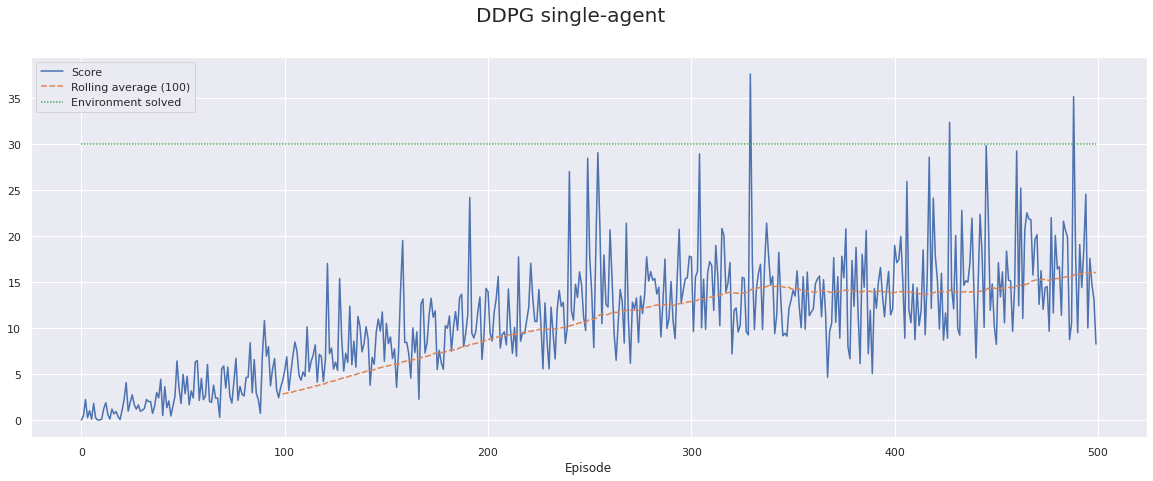

In [4]:
%%time
df_scores0 = train_and_plot(0)
needed_episodes_0 = num_episodes_to_solve(df_scores0)
print(f'The RL agent took {needed_episodes_0} episodes to solve the environment')

The RL agent took 108 episodes to solve the environment
CPU times: user 4h 54min 20s, sys: 2min 9s, total: 4h 56min 29s
Wall time: 5h 2min 56s


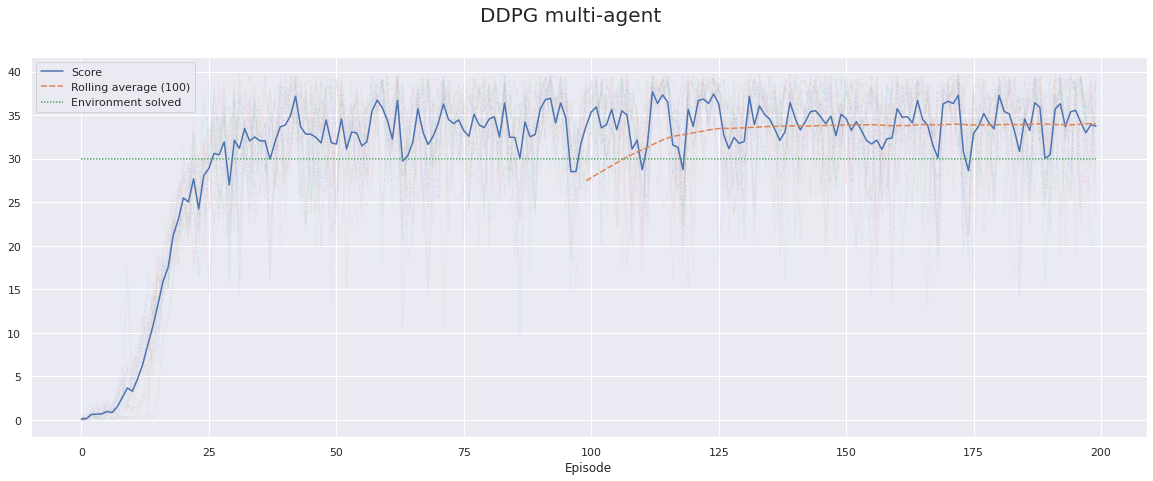

In [4]:
%%time
df_scores1 = train_and_plot(1)
needed_episodes_1 = num_episodes_to_solve(df_scores1)
print(f'The RL agent took {needed_episodes_1} episodes to solve the environment')

The RL agent took nan episodes to solve the environment
CPU times: user 44min 16s, sys: 58.5 s, total: 45min 15s
Wall time: 52min 49s


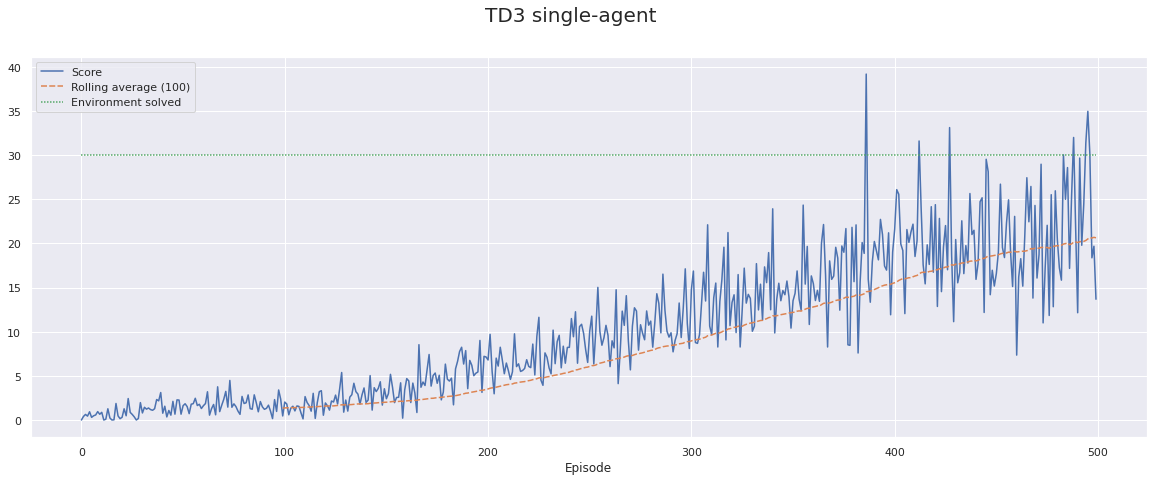

In [4]:
%%time
df_scores2 = train_and_plot(2)
needed_episodes_2 = num_episodes_to_solve(df_scores2)
print(f'The RL agent took {needed_episodes_2} episodes to solve the environment')

The RL agent took 100 episodes to solve the environment
CPU times: user 5h 15min 46s, sys: 1min 39s, total: 5h 17min 26s
Wall time: 5h 24min 3s


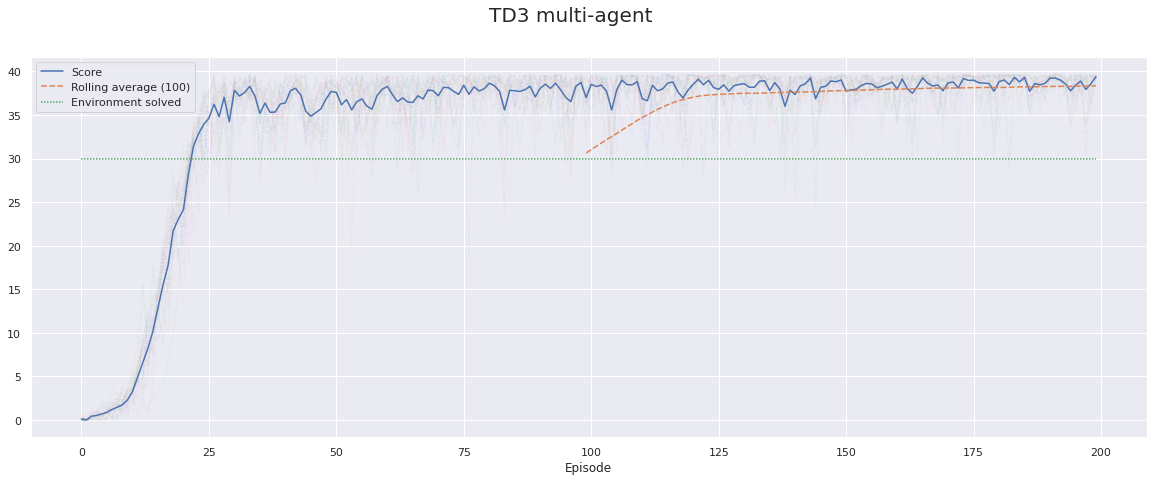

In [4]:
%%time
df_scores3 = train_and_plot(3)
needed_episodes_3 = num_episodes_to_solve(df_scores3)
print(f'The RL agent took {needed_episodes_3} episodes to solve the environment')

In [6]:
df_scores0['Rolling average (100)'].max()

16.05509964114055

In [7]:
df_scores1['Rolling average (100)'].max()

34.02424923949874

In [7]:
df_scores2['Rolling average (100)'].max()

20.689699537549167

In [5]:
df_scores3['Rolling average (100)'].max()

38.34192914299106

## Results
It is worth noting that the old version of Unity Environment prevents to launch a new environment after the previous one has been closed, requiring a kernel restart. Therefore, the following cell makes sure that the results obtained above across several sessions are hard coded into the current session. It is also worth noting that this issue no longer occurs on current versions of Unity ML-Agents.

In [19]:
needed_episodes_0 = np.nan
needed_episodes_1 = 108
needed_episodes_2 = np.nan
needed_episodes_3 = 100

title = 'Needed episodes to solve the environment'
needed_episodes_all = [needed_episodes_0, needed_episodes_1, needed_episodes_2, needed_episodes_3]
indexes = [ap['title'] for ap in agent_params]
needed_episodes = [num_episodes for num_episodes in needed_episodes_all if not pd.isna(num_episodes)]
indexes = [index for num_episodes, index in zip(needed_episodes_all, indexes) if not pd.isna(num_episodes)]
needed_episodes = pd.DataFrame(needed_episodes, index=indexes, columns=[title])
needed_episodes = needed_episodes.reset_index().rename(columns={'index': 'Algorithm'})

### Comparison of time to solve the environment
The following chart provides insightful information about the previous runs. It is necessary to say that it only shows information of a single training per case, while there exists high stochasticity. Therefore, it is not a thorough comparison. Even so, this has been a very interesting exercise in order to further understand the dynamics of the Deep Q Learning algorithm and three of its variants.

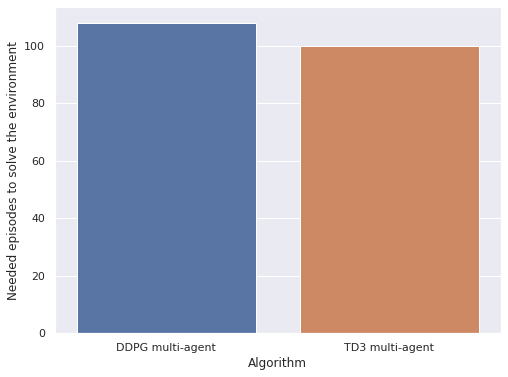

In [21]:
ax = sns.barplot(x='Algorithm', y=title, data=needed_episodes)
ax.figure.set_figheight(6)
ax.figure.set_figwidth(8)

## Watch the agents of the learned models interact with the environment

In [4]:
run_params = {'n_episodes': 2}
rolling_average_window = 1

def play_algorithm_in_environment(environment, filename, agent_params, run_params):
    multiagent = agent_params.pop('multiagent') if 'multiagent' in agent_params else False
    with environment(agent_params=agent_params, multiagent=multiagent) as env:
        env.load_parameters(filename)
        scores = env.play(**run_params)
    return scores

def play_and_plot(idx):
    multiagent = agent_params[idx]['params']['multiagent']
    filename = Path().resolve() / 'checkpoints' / f'checkpoint_{agent_params[idx]["title"]}'
    filename = filename if multiagent else f'{filename}.pt'
    scores = play_algorithm_in_environment(ReacherEnvironment, filename, agent_params[idx]['params'], run_params)
    clear_output()
    df_scores = format_df_scores(scores)
    plot_scores(df_scores, agent_params[idx]['title'])
    return df_scores

In [ ]:
%%time
_ = play_and_plot(3)